# Chapter 11. Risk Management

##### 목표 : stop loss order, take profit order와 같은 risk measure를 도입한 event-based backtesting pipeline 구현


1.   vectorized backtesting, event-based backtesting
2.   차트와 관련된 통계적 지표 (MDD, ATR) 분석
3.   일반적인 risk 지표를 고려한 backtesting (stop loss 등)





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd drive/MyDrive/Colab\ Notebooks

## Risk Management

In [84]:
#기본 settings
import os
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.float_format', '{:.4f}'.format)
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'

## Trading Bot

In [ ]:
import finance
import tradingbot
'''
chapter 9 에서 사용한 environment, agent 이용 (financial Q-learning agent)
'''

In [ ]:
symbol = 'EUR='
features = [symbol, 'r', 's', 'm', 'v']
'''
EUR/USD 데이터
r : log return (로그수익)
s : moving average (이동평균)
m : momentum (모멘텀)
v : rolling volatility (변동성)
d : np.where(r > 0, 1, 0) (상승 or 하락)
'''

In [87]:
a = 0
b = 1750
c = 250

In [ ]:
learn_env = finance.Finance(symbol, features, window=20, lags=3,
                 leverage=1, min_performance=0.9, min_accuracy=0.475,
                 start=a, end=a + b, mu=None, std=None)
'''
window : momentum 등등 구할때 window size
lags : lag in time series
min_performance, min_accuracy : 만족해야 하는 최소 gross performance, accuracy
'''

In [89]:
learn_env.data.info()
'''
end-of-day(EOD) data
2010~2016
'''

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1750 entries, 2010-02-02 to 2017-01-12
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    1750 non-null   float64
 1   r       1750 non-null   float64
 2   s       1750 non-null   float64
 3   m       1750 non-null   float64
 4   v       1750 non-null   float64
 5   d       1750 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 95.7 KB


'\nend-of-day(EOD) data\n2010~2016\n'

In [90]:
valid_env = finance.Finance(symbol, features=learn_env.features,
                            window=learn_env.window,
                            lags=learn_env.lags,
                            leverage=learn_env.leverage,
                            min_performance=0.0, min_accuracy=0.0,
                            start=a + b, end=a + b + c,
                            mu=learn_env.mu, std=learn_env.std)

In [91]:
valid_env.data.info()
'''
end-of-day(EOD) data
2017~2018
'''

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2017-01-13 to 2018-01-10
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    250 non-null    float64
 1   r       250 non-null    float64
 2   s       250 non-null    float64
 3   m       250 non-null    float64
 4   v       250 non-null    float64
 5   d       250 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.7 KB


'\n2017~2018\n'

In [ ]:
tradingbot.set_seeds(100)
agent = tradingbot.TradingBot(24, 0.001, learn_env, valid_env)
'''
DQL agent
hidden_units = 24
lr = 0.001
'''

In [93]:
episodes = 61

In [94]:
 %time agent.learn(episodes)
 '''
 performance : gross performance -> 1 미만이면 손해
 eps : exploration rate
 '''

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


episode: 10/61 | VALIDATION | treward:  247 | perf: 0.890 | eps: 0.95
episode: 20/61 | VALIDATION | treward:  247 | perf: 0.969 | eps: 0.86
episode: 30/61 | VALIDATION | treward:  247 | perf: 0.890 | eps: 0.78
episode: 40/61 | VALIDATION | treward:  247 | perf: 0.953 | eps: 0.70
episode: 50/61 | VALIDATION | treward:  247 | perf: 0.956 | eps: 0.64
episode: 60/61 | VALIDATION | treward:  247 | perf: 0.870 | eps: 0.58

CPU times: user 52.7 s, sys: 1.92 s, total: 54.6 s
Wall time: 50.5 s


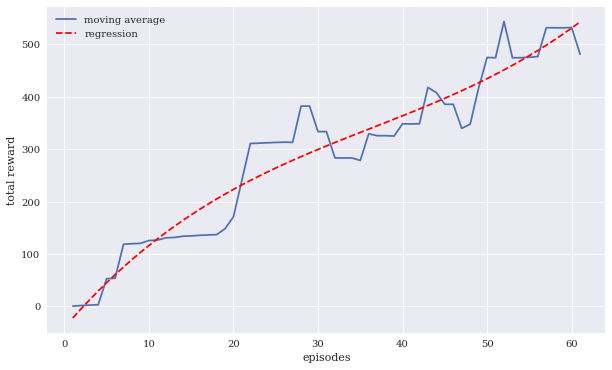

In [95]:
tradingbot.plot_treward(agent)
'''
training data에 대해서는 total reward(의 moving average)의 증가하는 경향성을 확인할 수 있다
'''

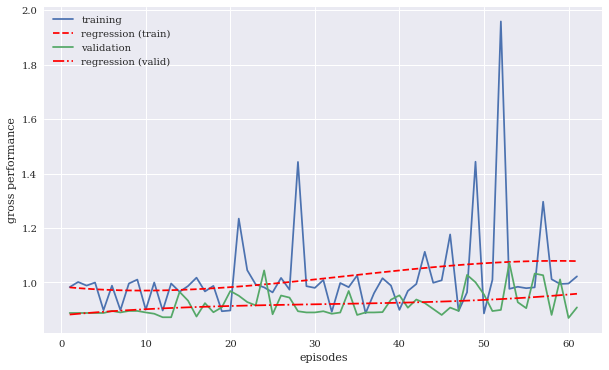

In [96]:
tradingbot.plot_performance(agent)
'''
gross performance의 경우 validation dataset에 대해서 1 미만의 performance를 보이고 있다
exploration 으로 인해 variance가 발생한다
validation dataset에 대해서는 exploitation만 사용한다
'''

## Vectorized Backtesting

In [97]:
def reshape(s):
    return np.reshape(s, [1, learn_env.lags,
                          learn_env.n_features])

In [98]:
def backtest(agent, env):
    env.min_accuracy = 0.0
    env.min_performance = 0.0
    done = False
    env.data['p'] = 0 #포지션 column
    state = env.reset()
    while not done:
        action = np.argmax(
            agent.model.predict(reshape(state))[0, 0])
        position = 1 if action == 1 else -1 #predicted 포지션 (롱/숏)
        env.data.loc[:, 'p'].iloc[env.bar] = position
        state, reward, done, info = env.step(action) #다음 state, reward, info 등을 output
    env.data['s'] = env.data['p'] * env.data['r'] * learn_env.leverage #log return
'''
data['p'] : 포지션 
trained model이 현재 state에서 predict한 optimal action(포지션)을 실행
data['s'] : 추측된 포지션에 기반한 return을 계산
'''

In [99]:
env = agent.learn_env
'''
training data
'''

In [100]:
backtest(agent, env)

In [101]:
env.data['p'].iloc[env.lags:].value_counts()

 1    1143
-1     604
Name: p, dtype: int64

In [102]:
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp)

r   0.7725
s   1.3492
dtype: float64

In [103]:
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp) - 1
'''
start에 매수하여 end에 매도하는 전략보다 net performance가 더 좋음
'''

r   -0.2275
s    0.3492
dtype: float64

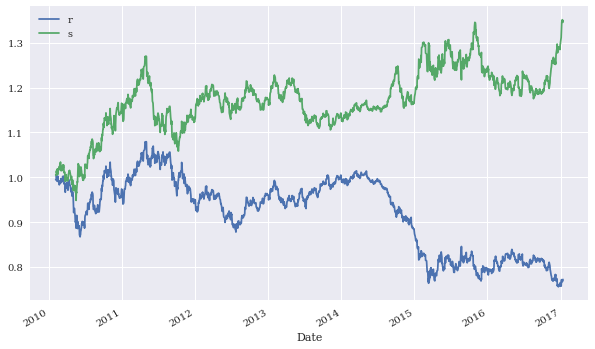

In [104]:
env.data[['r', 's']].iloc[env.lags:].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));

In [105]:
test_env = finance.Finance(symbol, features=learn_env.features,
                           window=learn_env.window,
                           lags=learn_env.lags,
                           leverage=learn_env.leverage,
                           min_performance=0.0, min_accuracy=0.0,
                           start=a + b + c, end=None,
                           mu=learn_env.mu, std=learn_env.std)

In [106]:
env = test_env
'''
test dataset
2018~2019
'''

In [107]:
backtest(agent, env)

In [108]:
env.data['p'].iloc[env.lags:].value_counts()

-1    431
 1     62
Name: p, dtype: int64

In [109]:
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp)

r   0.9144
s   1.1092
dtype: float64

In [110]:
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp) - 1
'''
test dataset의 경우에도 start에 매수하여 end에 매도하는 전략보다 net performance가 더 좋음
'''

r   -0.0856
s    0.1092
dtype: float64

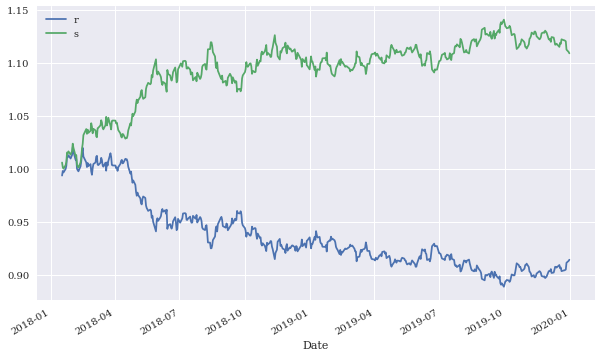

In [111]:
env.data[['r', 's']].iloc[env.lags:].cumsum(
            ).apply(np.exp).plot(figsize=(10, 6));

'''
test performance (without event-based risk measure)
'''

## Event-Based Backtesting

##### stop loss order과 같은 risk measure를 분석하기 위해서는 event-based backtesting이 필요하다

In [112]:
import backtesting as bt
'''
event-based backtesting을 통한 risk measure를 이용하여 performance를 측정해보자
'''

In [113]:
bb = bt.BacktestingBase(env=agent.learn_env, model=agent.model,
                        amount=10000, ptc=0.0001, ftc=1.0,
                        verbose=True) 
'''
거래비용 고려
initial amount : 초기자금 (10000)
ptc : proportional transaction cost (비례 거래비용 0.01%)
ftc : 고정 거래비용
'''

In [114]:
bb.initial_amount

10000

In [115]:
bar = 100
'''
100번째 data
'''

In [116]:
bb.get_date_price(bar)
'''
날짜, 가격
'''

('2010-06-25', 1.2374)

In [117]:
bb.env.get_state(bar)
'''
현재 bar의 state (이전 3일동안의 feature)
'''

,EUR=,r,s,m,v
Date,,,,,
2010-06-22,-0.0242,-0.5622,-0.0916,-0.2022,1.5316
2010-06-23,0.0176,0.6940,-0.0939,-0.0915,1.5563
2010-06-24,0.0354,0.3034,-0.0865,0.6391,1.0890


In [118]:
bb.place_buy_order(bar, amount=5000)
'''
buy order 예시
'''

2010-06-25 | buy 4040 units for 1.2374
2010-06-25 | current balance = 4999.40


In [119]:
bb.print_net_wealth(2 * bar)
'''
현재 time(200) 에 대한 net wealth (cash + position)
'''

2010-11-16 | net wealth = 10450.17


In [120]:
bb.place_sell_order(2 * bar, units=1000)

2010-11-16 | sell 1000 units for 1.3492
2010-11-16 | current balance = 6347.47


In [121]:
bb.close_out(3 * bar)
'''
포지션 정리
'''

2011-04-11 | *** CLOSING OUT ***
2011-04-11 | sell 3040 units for 1.4434
2011-04-11 | current balance = 10733.97
2011-04-11 | net performance [%] = 7.3397
2011-04-11 | number of trades [#] = 3


In [122]:
'''
event-based backtesting (거래수수료 고려)
'''
class TBBacktester(bt.BacktestingBase):
    def _reshape(self, state):
        ''' Helper method to reshape state objects.
        '''
        return np.reshape(state, [1, self.env.lags, self.env.n_features])
    def backtest_strategy(self):
        ''' Event-based backtesting of the trading bot's performance.
        '''
        self.units = 0
        self.position = 0
        self.trades = 0
        self.current_balance = self.initial_amount
        self.net_wealths = list()
        for bar in range(self.env.lags, len(self.env.data)):
            date, price = self.get_date_price(bar)
            if self.trades == 0:
                print(50 * '=')
                print(f'{date} | *** START BACKTEST ***')
                self.print_balance(bar)
                print(50 * '=')
            state = self.env.get_state(bar) #현재 data의 state 불러오기
            action = np.argmax(self.model.predict( #최적의 action 예측하기
                        self._reshape(state.values))[0, 0])
            position = 1 if action == 1 else -1 #optimal action에 따른 position
            if self.position in [0, -1] and position == 1: # 롱 포지션
                if self.verbose:
                    print(50 * '-')
                    print(f'{date} | *** GOING LONG ***')
                if self.position == -1:
                    self.place_buy_order(bar - 1, units=-self.units)
                self.place_buy_order(bar - 1,
                                     amount=self.current_balance)
                if self.verbose:
                    self.print_net_wealth(bar)
                self.position = 1
            elif self.position in [0, 1] and position == -1: #숏 포지션
                if self.verbose:
                    print(50 * '-')
                    print(f'{date} | *** GOING SHORT ***')
                if self.position == 1:
                    self.place_sell_order(bar - 1, units=self.units)
                self.place_sell_order(bar - 1,
                                      amount=self.current_balance)
                if self.verbose:
                    self.print_net_wealth(bar)
                self.position = -1
            self.net_wealths.append((date,
                                     self.calculate_net_wealth(price)))
        self.net_wealths = pd.DataFrame(self.net_wealths, #net wealth 저장
                                        columns=['date', 'net_wealth'])
        self.net_wealths.set_index('date', inplace=True)
        self.net_wealths.index = pd.DatetimeIndex(
                                        self.net_wealths.index)
        self.close_out(bar)

In [123]:
env = learn_env

In [124]:
tb = TBBacktester(env, agent.model, 10000,
                  0.0, 0, verbose=False)
'''
거래수수료 = 0원
'''

In [125]:
tb.backtest_strategy()

2010-02-05 | *** START BACKTEST ***
2010-02-05 | current balance = 10000.00
2017-01-12 | *** CLOSING OUT ***
2017-01-12 | current balance = 13135.16
2017-01-12 | net performance [%] = 31.3516
2017-01-12 | number of trades [#] = 724


In [126]:
tb_ = TBBacktester(env, agent.model, 10000,
                   0.00012, 0.0, verbose=False)
'''
ptc : 0.012%
'''

In [127]:
tb_.backtest_strategy()

2010-02-05 | *** START BACKTEST ***
2010-02-05 | current balance = 10000.00
2017-01-12 | *** CLOSING OUT ***
2017-01-12 | current balance = 12042.90
2017-01-12 | net performance [%] = 20.4290
2017-01-12 | number of trades [#] = 724


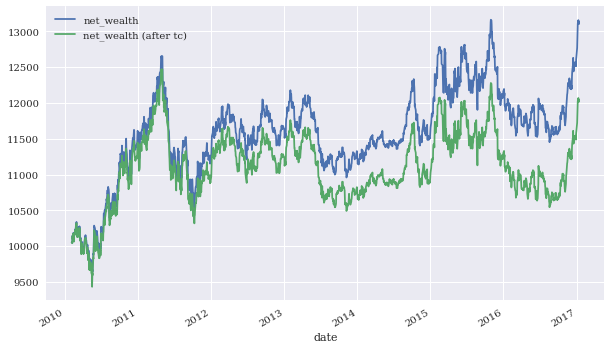

In [128]:
ax = tb.net_wealths.plot(figsize=(10, 6))
tb_.net_wealths.columns = ['net_wealth (after tc)']
tb_.net_wealths.plot(ax=ax);

In [129]:
env = test_env
'''
test dataset
'''

In [130]:
tb = TBBacktester(env, agent.model, 10000,
                  0.0, 0, verbose=False)

In [131]:
tb.backtest_strategy()

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 11060.18
2019-12-31 | net performance [%] = 10.6018
2019-12-31 | number of trades [#] = 78


In [132]:
tb_ = TBBacktester(env, agent.model, 10000,
                   0.00012, 0.0, verbose=False)

In [133]:
tb_.backtest_strategy()

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 10957.48
2019-12-31 | net performance [%] = 9.5748
2019-12-31 | number of trades [#] = 78


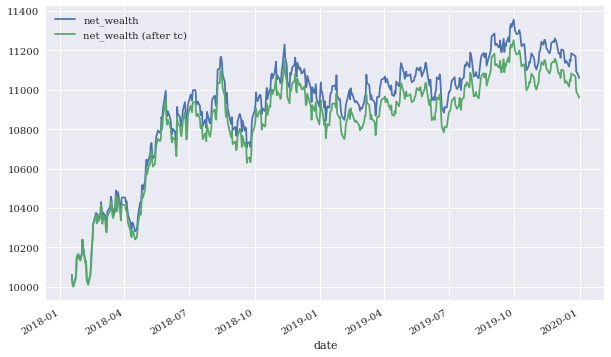

In [134]:
ax = tb.net_wealths.plot(figsize=(10, 6))
tb_.net_wealths.columns = ['net_wealth (after tc)']
tb_.net_wealths.plot(ax=ax);

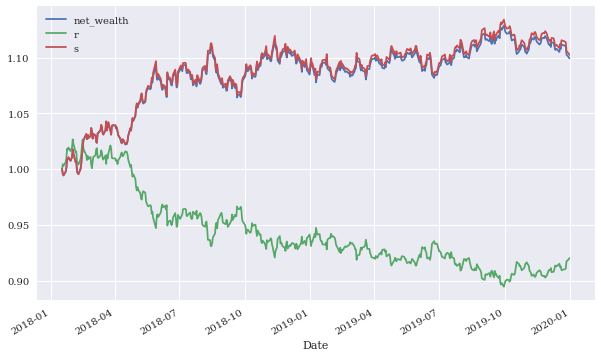

In [135]:
ax = (tb.net_wealths / tb.net_wealths.iloc[0]).plot(figsize=(10, 6))
tp = env.data[['r', 's']].iloc[env.lags:].cumsum().apply(np.exp)
(tp / tp.iloc[0]).plot(ax=ax);
'''
normalize하면 거의 비슷하다
'''

## Assessing Risk

In [ ]:
'''
risk measure의 예시
- nondirected risk measure : volatility(변동성), average true range(ATR) 
- directed risk measure : maximum drawdown(MDD), value-at-risk(VAR)(최대예상손실액)
'''
'''
stop loss, trailing stop loss, take profit 의 threshold를 정할 때 ATR을 이용할 수 있다
'''

**TR(True Range)** : 
1.   당일 최고가 - 최저가 $(H-L)$
2.   당일 최고가 - 전일 종가의 절대값 $|H-C_P|$
3.   당일 최저가 - 전일 종가의 절대값 $|L-C_P|$

세 값들 중 가장 큰 값 = True Range

$$
TR = max((H-L),|H-C_P|,|L-C_P|)
$$



**ATR(Average True Range)** : 시장의 변동성을 측정하는 지표 중 하나. true range의 이동평균 (n=14)
$$
ATR = \frac{1}{n}∑_{i=1}^n TR_i
$$

In [136]:
data = pd.DataFrame(learn_env.data[symbol])

In [137]:
data.head()
#가격

,EUR=
Date,
2010-02-02,1.3961
2010-02-03,1.3898
2010-02-04,1.3734
2010-02-05,1.3662
2010-02-08,1.3652


In [138]:
window = 14

In [139]:
data['min'] = data[symbol].rolling(window).min()
#rolling minimum

In [140]:
data['max'] = data[symbol].rolling(window).max()
#rolling maximum

In [141]:
data['mami'] = data['max'] - data['min']
#당일 최고가 - 최저가

In [142]:
data['mac'] = abs(data['max'] - data[symbol].shift(1))
#당일 최고가 - 전일 종가의 절대값

In [143]:
data['mic'] = abs(data['min'] - data[symbol].shift(1))
#당일 최저가 - 전일 종가의 절대값

In [144]:
data['atr'] = np.maximum(data['mami'], data['mac'])

In [145]:
data['atr'] = np.maximum(data['atr'], data['mic'])
# ATR feature

In [146]:
data['atr%'] = data['atr'] / data[symbol]
# ATR (%)

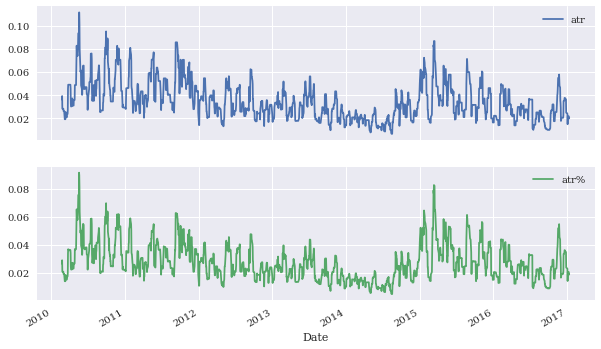

In [147]:
data[['atr', 'atr%']].plot(subplots=True, figsize=(10, 6));

In [148]:
data[['atr', 'atr%']].tail()
'''
practical하게 설정하는 일반적인 stop loss threshold = 진입가격 * (1 - atr%)
'''

,atr,atr%
Date,,
2017-01-06,0.0218,0.0207
2017-01-09,0.0218,0.0206
2017-01-10,0.0218,0.0207
2017-01-11,0.0199,0.0188
2017-01-12,0.0206,0.0194


In [149]:
leverage = 10

In [150]:
data[['atr', 'atr%']].tail() * leverage
'''
stop loss threshold = 진입가격 * (1 - atr% * leverage)
'''

,atr,atr%
Date,,
2017-01-06,0.2180,0.2070
2017-01-09,0.2180,0.2062
2017-01-10,0.2180,0.2066
2017-01-11,0.1990,0.1881
2017-01-12,0.2060,0.1942


In [151]:
data[['atr', 'atr%']].median() * leverage
'''
이 예시에서는 atr% * leverage 의 중간값이 약 0.25이므로, stop loss의 가격은 (진입가격 * 0.75) 로 설정한다
'''
'''
atr는 차트가 내재하고 있는 'noise'의 정도라고 해석할 수 있다. 즉, atr의 비율까지 stop loss를 실행하지 않는다는 것은
 noise 수준의 변동까지는 감수한다는 것으로 해석할 수 있다.
'''
'''
take profit에서도 적용가능하다
'''

atr    0.3180
atr%   0.2481
dtype: float64

## Backtesting Risk Measures

In [152]:
import tbbacktesterrm as tbbrm

In [153]:
env = test_env

In [154]:
tb = tbbrm.TBBacktesterRM(env, agent.model, 10000,
                          0.0, 0, verbose=False)
'''
이전 거래의 entry price, 그 거래 이후로의 maximum price 와 minimum price를 저장할 수 있다
'''

In [155]:
tb.backtest_strategy(sl=None, tsl=None, tp=None, wait=5)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 11060.18
2019-12-31 | net performance [%] = 10.6018
2019-12-31 | number of trades [#] = 78


### Stop Loss

In [156]:
tb.backtest_strategy(sl=0.0175, tsl=None, tp=None,
                     wait=5, guarantee=False)

'''
현재가가 포지션의 진입가 대비 일정수준의 손실 이 이루어지면(1.75%) 포지션 정리
더 낮은 performance
'''

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0201) ***
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 10936.03
2019-12-31 | net performance [%] = 9.3603
2019-12-31 | number of trades [#] = 80


In [157]:
tb.backtest_strategy(sl=0.017, tsl=None, tp=None,
                     wait=5, guarantee=True)

'''
guarantee = True : 포지션을 정리할 때 volatility와 관계없이 지정한 가격으로 정리가 가능하도록 보장하는 것
일반 stop-loss에서는 슬리피지 등으로 인해 보장될 수 없다
더 낮은 performance
'''

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0170) ***
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 10970.21
2019-12-31 | net performance [%] = 9.7021
2019-12-31 | number of trades [#] = 80


### Trailing Stop Loss

In [158]:
tb.backtest_strategy(sl=None, tsl=0.015,
                     tp=None, wait=5)

'''
현재가가 포지션의 고점(저점) 대비 일정수준의 하락(상승) 이 이루어지면(1.5%) 포지션 정리
더 낮은 performance
'''

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** TRAILING SL (LONG  | -0.0201) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0192) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0195) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0158) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0171) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0207) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0151) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0192) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0179) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0155) ***
----------------------------------

### Take Profit

In [159]:
tb.backtest_strategy(sl=None, tsl=None, tp=0.015,
                     wait=5, guarantee=False)
'''
현재 포지션의 수익이 진입가격 대비 일정수준 이상일 때(1.5%), 포지션을 정리한다
(guarantee = false)
'''

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** TAKE PROFIT (LONG  | 0.0221) ***
--------------------------------------------------
*** TAKE PROFIT (LONG  | 0.0152) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0200) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0188) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0214) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0173) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0213) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0153) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0202) ***
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 11163.67
2019-12-31 | net performance [%] = 11.6367
2019-12-31 | num

In [160]:
tb.backtest_strategy(sl=None, tsl=None, tp=0.015,
                     wait=5, guarantee=True)
'''
(guarantee = true)
'''

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** TAKE PROFIT (LONG  | 0.0150) ***
--------------------------------------------------
*** TAKE PROFIT (LONG  | 0.0150) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0150) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0150) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0150) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0150) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0150) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0150) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0150) ***
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 10770.38
2019-12-31 | net performance [%] = 7.7038
2019-12-31 | numb

## Combinations

In [161]:
tb.backtest_strategy(sl=0.015, tsl=None,
                     tp=0.0185, wait=5)
'''
일반적으로 risk를 낮추면 performance가 줄어든다
'''

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** TAKE PROFIT (LONG  | 0.0221) ***
--------------------------------------------------
*** TAKE PROFIT (LONG  | 0.0198) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0200) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0188) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0214) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0171) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0158) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0223) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0237) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0201) ***
-----------------------------------------------

In [162]:
tb.backtest_strategy(sl=None, tsl=0.02,
                     tp=0.02, wait=5)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** TAKE PROFIT (LONG  | 0.0221) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0200) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0227) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0214) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0216) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0214) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0205) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0207) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0213) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0209) ***
----------------------------------------

##### 결론


*   DQL agent의 vectorized, event-based backtesting을 진행하였다 
*   ATR을 통해 전형적인 noise의 정도를 분석하였으며, 이를 기반으로 stop loss등의 기법을 구현해 보았다
*   event-based backtesting은 알고리즘적 유연성을 가지며 여러가지 risk measure의 backtesting에 유연하게 적용 가능하다
*   일반적으로, risk reducing에 따라 퍼포먼스는 줄어들 수 있지만, 적합하게 조절된다면, take profit order처럼 퍼포먼스에 좋은 영향을 줄 수도 있다


